In [38]:
# colab에서 드라이브 내 폴더 사용 위해 마운트
# from google.colab import drive

# drive.mount('/content/drive/')

# 폴더까지의 경로
# cd '/content/drive/MyDrive/GSA_Creative_Resarch/rock_sci_paper'

In [39]:
import os
import torch
import torchvision.transforms as transforms
import dataset
import model
import torch.nn.functional as F


In [40]:
# 각종 path및 하이퍼 파라미터 설정
data_path = 'C:\\Users\\USER\\Desktop\\GSH_CRP\\codes\\rock_sci_paper\\data\\pic128'
save_path = 'C:\\Users\\USER\\Desktop\\GSH_CRP\\codes\\rock_sci_paper\\model_para'
batch_size = 16
seed = 0

In [41]:
# seed 설정
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [42]:
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

vis_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128))]
)

test_dataset = dataset.RockScissorsPaper(
    transform=test_transform,
    path = data_path,
    mode = 'test'
)
test_vis = dataset.RockScissorsPaper(
    transform=vis_transform,
    path = data_path,
    mode = 'test'
)

In [43]:
model = model.ResNet18(num_classes=3)
model = model.to(device)

# model.load_state_dict(torch.load(os.path.join(save_path, 'lr_teacher.pth')))
model.load_state_dict(torch.load(os.path.join(save_path, 'student.pth')))

<All keys matched successfully>

In [44]:
index = 16
sample, label = test_dataset[index]
vis_sample, _ = test_vis[index]

h,w = sample.shape[-2], sample.shape[-1]
sample = F.interpolate(sample.unsqueeze(0), (h//8, w//8))
sample = F.interpolate(sample, (h,w))
sample = sample.squeeze()

vis_sample = vis_sample.resize((16,16))
vis_sample = vis_sample.resize((128,128))

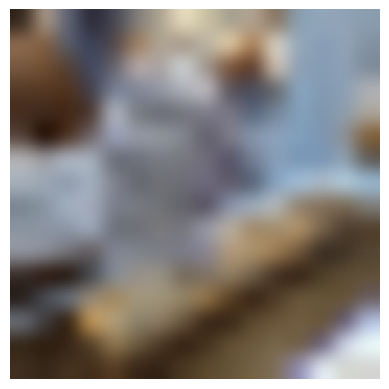

label is  rock


In [45]:
import matplotlib.pyplot as plt

plt.imshow(vis_sample)
plt.axis('off')
plt.show()

label_dict = {0:'rock', 1:'scissor', 2:'paper'}
print('label is ', label_dict[label])

In [46]:
# sample 이미지를 모델에 넣을 수 있도록 차원을 조정
sample = sample.unsqueeze(0).to(device)

# model을 eval 모드로 전환
model.eval()
output, f4, _, _, _ = model(sample)
_, pred = torch.max(output, 1)
print("Prediction is ", label_dict[pred.item()])

# Class Activation Map(CAM) 생성
# CAM은 마지막 단의 피쳐와 클래스 분류하는데 사용되는 Fully Connected Layer의 weight를 이용하여 생성

# 모델에서 마지막단을 Flatten하여 h*w 값을 가지기 때문에 루트 씌워서 각각의 height, width를 구함
h, w = int(f4.shape[-1]**0.5), int(f4.shape[-1]**0.5)
weights = list(model.parameters())[-2].data

# Prediction한 클래스의 Activation Map을 확인하기 위해 전체 weight 중 해당 클래스의 것만 가져옴
weight = weights[pred.item()]
weight = weight.unsqueeze(0).unsqueeze(0)
cam = torch.bmm(weight, f4)
cam = torch.reshape(cam, (1, h, w))

# Min/Max Normalization
cam = cam - torch.min(cam)
cam = cam / torch.max(cam)
cam = cam.unsqueeze(1)

cam = F.interpolate(cam, size=(128,128))

Prediction is  rock


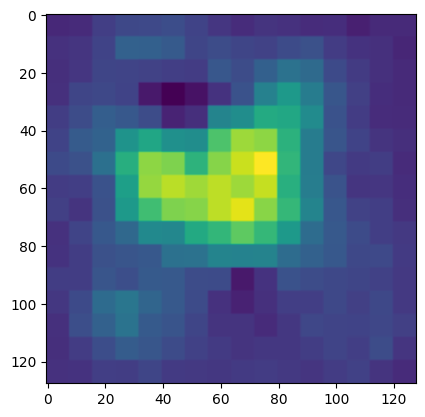

In [47]:
cam = cam.detach().cpu().numpy()
plt.imshow(cam[0].reshape(128,128,1))
plt.show()